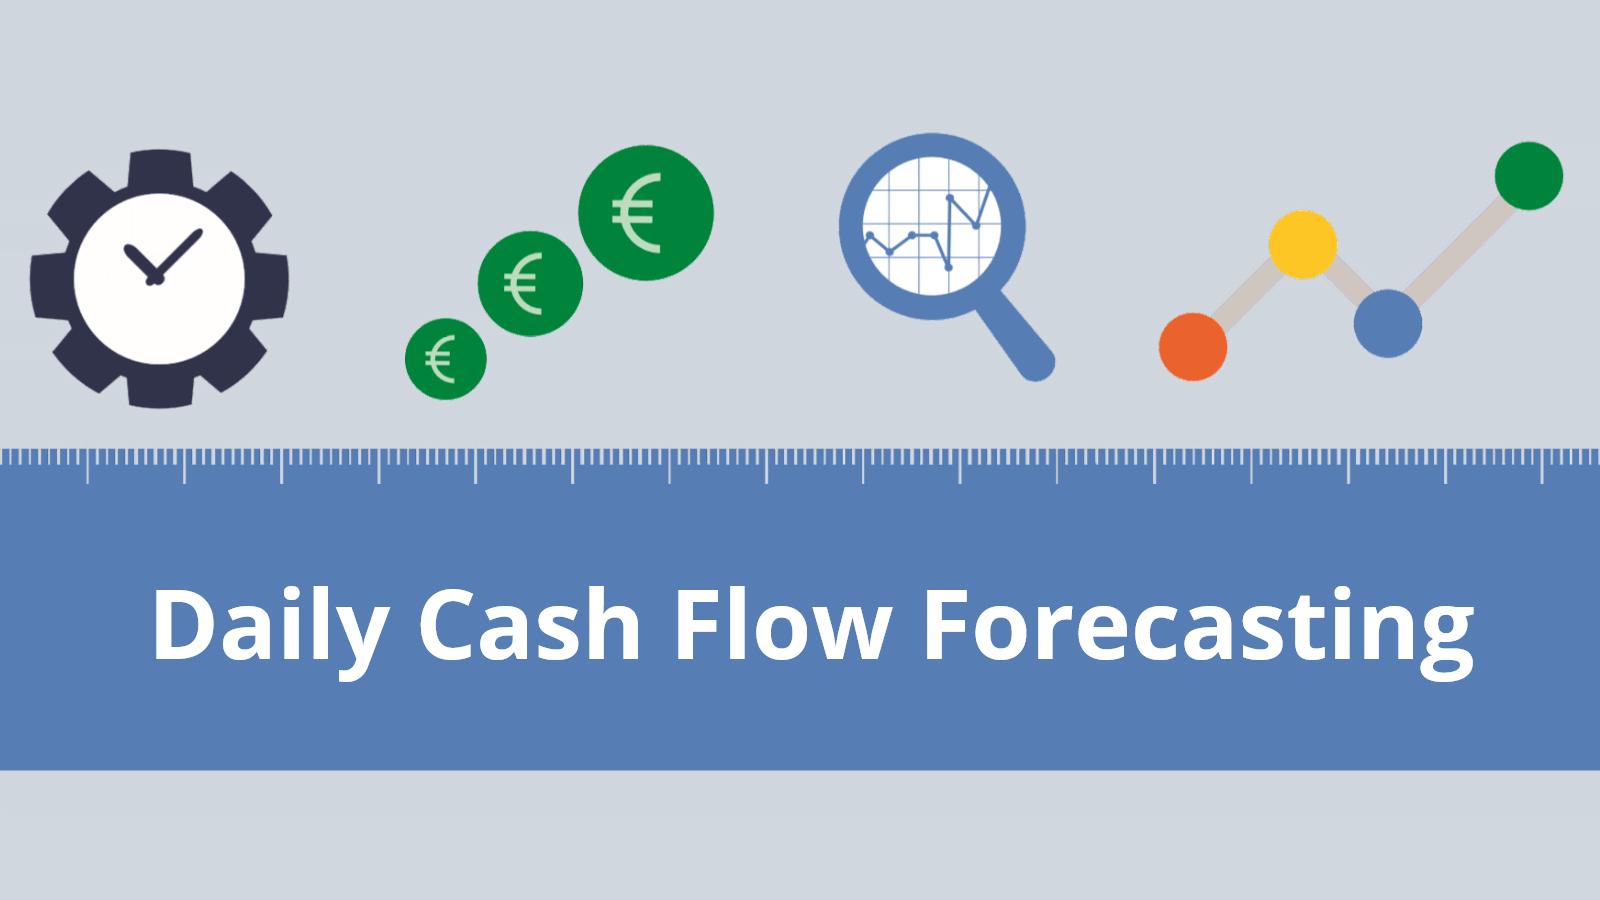

## Sample study for forecasting Daily Cash Flow in 6 branches of Delhi zone of PNB, a Public Sector Bank.
##### 1. Here we have imported the libraries at first.
##### 2. The data is read and preprocessed to make it in the desired form.
##### 3. A function is made which is having the following parts:
1. 4 dataframes are defined : two for Pay(test & train) and two for Receipt(test & train)
2. A for-loop is run taking each branch at a time. Inside the for-loop:
    1. A holiday function is defined which takes the dataframe as an input and forms a holiday dataframe with the list of dates having holiday effects with the name of the holiday, i.e., weekends, national and local holidays, and another two columns viz. lower_window and upper_window.
    2. The initial dataframe is divided into two dataframes, one for Pay and one for Receipt. These dataframes are futher divided into test and train sets.
    3. A forecast function is defined which takes the pay/receipt train/test dataset, the future dates to be forecasted as an input and returns a dataframe having all the forecasted values and its confidence intervals and the holiday effects.
    4. Two functions, one for rmse, and one for mape, are defined which are used in the details function, which is taking the data and the forecasted data as input and returns some specified metrics from the input.
    5. All the details are appended in a dataframe. Thus we get 4 dataframes: pay_train, pay_test, receipt_train, receipt_test. These 4 dataframes are saved in the system directly.

In [1]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time

C:\Users\RAKTIMA\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
data = pd.read_excel("delhi_zone_6_branches_Manjis.xlsx")
data

,Branch,Date,TOT_PAY,TOT_RCPT
0,Del_Br_1,2021-01-01,6.490000,25.73000
1,Del_Br_1,2021-01-02,15.390000,30.76000
2,Del_Br_1,2021-01-04,26.160000,56.91000
3,Del_Br_1,2021-01-05,16.010000,25.62000
4,Del_Br_1,2021-01-06,11.420000,22.98000
...,...,...,...,...
2228,Del_Br_6,2022-06-24,16.789000,9.77101
2229,Del_Br_6,2022-06-27,13.983000,13.04400
2230,Del_Br_6,2022-06-28,15.770088,7.05678
2231,Del_Br_6,2022-06-29,14.601000,4.03800


In [3]:
def whole(data):
    global df_pay_train 
    df_pay_train = pd.DataFrame(columns = ['rmse', 'mape', 'avg_act', 'avg_pred', 'stdev', 'min', 'max', 'cnt_neg_pred'])
    global df_pay_test 
    df_pay_test = pd.DataFrame(columns = ['rmse', 'mape', 'avg_act', 'avg_pred', 'stdev', 'min', 'max', 'cnt_neg_pred'])
    global df_receipt_train 
    df_receipt_train = pd.DataFrame(columns = ['rmse', 'mape', 'avg_act', 'avg_pred', 'stdev', 'min', 'max', 'cnt_neg_pred'])
    global df_receipt_test 
    df_receipt_test = pd.DataFrame(columns = ['rmse', 'mape', 'avg_act', 'avg_pred', 'stdev', 'min', 'max', 'cnt_neg_pred'])
    bran = data['Branch'].unique()
    x = 0
    for x in range(len(bran)):
        data12 = bran[x]
        data1 = data[data['Branch'] == data12]
        data1.drop('Branch', inplace = True, axis = 1)
        data1.columns
        data1 = data1.reset_index(drop = True)

        def holiday(data1):
            global hol
            upper_window = []
            lower_window = [0]
            da1 = data1['Date']
    
            for i in range(len(da1) - 1):
                deltap = da1[i+1] - da1[i]
                upper_window.append(deltap.days - 1)
            for i in range(len(da1)):
                if i != 0:
                    deltan = da1[i-1] - da1[i]
                    lower_window.append(deltan.days + 1)
            upper_window.append(0)

            h = pd.concat([da1, pd.DataFrame(lower_window), pd.DataFrame(upper_window)], axis = 1)
            h.columns = ["ds", "lower_window", "upper_window"]

            h2 = h.drop(h[(h['lower_window'] == 0) & (h['upper_window'] == 0)].index)
            h2 = h2.reset_index(drop = True)

            ld = list(h2['ds'])
            lw = list(h2['lower_window'])
            lu = list(h2['upper_window'])

            holiday = []
            for i in range(len(h2)):
                if((ld[i] == pd.to_datetime('2021-01-25')) | (ld[i] == pd.to_datetime('2021-01-27')) | (ld[i] == pd.to_datetime('2021-04-01')) | 
                (ld[i] == pd.to_datetime('2021-04-03')) | (ld[i] == pd.to_datetime('2021-08-14'))| (ld[i] == pd.to_datetime('2021-08-16')) | 
                (ld[i] == pd.to_datetime('2021-10-01')) | (ld[i] == pd.to_datetime('2021-10-03')) | (ld[i] == pd.to_datetime('2021-12-24')) | 
                (ld[i] == pd.to_datetime('2021-12-26'))):
                    holiday.append('national')       

                elif (lw[i] == 0) & (lu[i] == 1):
                    holiday.append('hol_wk_sat1')

                elif (lw[i] == -1) & (lu[i] == 0):
                    holiday.append('hol_wk_mon1')

                elif (lw[i] == 0) & (lu[i] == 2):
                    holiday.append('hol_wk_fri2')

                elif (lw[i] == -2) & (lu[i] == 0):
                    holiday.append('hol_wk_mon2')

                else:
                    holiday.append('local')

            hol = pd.concat([pd.DataFrame(holiday), h2], axis = 1)
            hol.columns = ['holiday', 'ds', 'lower_window', 'upper_window']
            return hol
        holi = holiday(data1)

        data1_p = data1.loc[:, ['Date','TOT_PAY']]
        data1_r = data1.loc[:, ['Date', 'TOT_RCPT']]
        data1_p = data1_p[data1_p['TOT_PAY'] > 0.10]
        data1_r = data1_r[data1_r['TOT_RCPT'] > 0.10]
        data1_p.columns = ['ds', 'y']
        data1_r.columns = ['ds', 'y']

        p_train = data1_p.loc[(data1_p['ds'] <= '2022-05-31')]
        p_test = data1_p.loc[(data1_p['ds'] > '2022-05-31')]
        r_train = data1_r.loc[(data1_r['ds'] <= '2022-05-31')]
        r_test = data1_r.loc[(data1_r['ds'] > '2022-05-31')]


        def forecast(data2, future):
            m = Prophet(yearly_seasonality = False, weekly_seasonality = True, daily_seasonality = False,
                       holidays = holi)
            m.fit(data2)
            forecast1 = m.predict(future)
            return forecast1

        pred_p_train = forecast(p_train, pd.DataFrame({'ds' : p_train['ds']}))
        pred_p_test = forecast(p_train, pd.DataFrame({'ds' : p_test['ds']}))
        pred_r_train = forecast(r_train, pd.DataFrame({'ds' : r_train['ds']}))
        pred_r_test = forecast(r_train, pd.DataFrame({'ds' : r_test['ds']}))

        def rmse(actual, pred):
            result = sqrt(mean_squared_error(actual, pred))
            return result

        def mape(actual1, pred1):
            actual1 = np.array(actual1)
            pred1 = np.array(pred1)
            result1 = np.mean(np.abs((actual1 - pred1) / actual1)) * 100
            return result1

        def details(data, fore_data):
            rms_err = rmse(data['y'], fore_data['yhat']) 
            map_err = mape(data['y'], fore_data['yhat'])
            avg_act = data['y'].mean()
            avg_pred = fore_data['yhat'].mean()
            stdev = fore_data['yhat'].std()
            minimum = fore_data['yhat'].min()
            maximum = fore_data['yhat'].max()
            cnt_neg_pred = (fore_data['yhat'] <= 0).sum()
            
            df1 = pd.DataFrame([rms_err, map_err, avg_act, avg_pred, stdev, minimum, maximum, cnt_neg_pred])
            df1 = df1.T
            df1.columns = ['rmse', 'mape', 'avg_act', 'avg_pred', 'stdev', 'min', 'max', 'cnt_neg_pred']
            return df1
        dptr = details(p_train, pred_p_train)
        dpte = details(p_test, pred_p_test)
        drtr = details(r_train, pred_r_train)
        drte = details(r_test, pred_r_test)
    #     print(df_pay_train)
        frames1 = [df_pay_train, dptr]
        frames2 = [df_pay_test, dpte]
        frames3 = [df_receipt_train, drtr]
        frames4 = [df_receipt_test, drte]
        df_pay_train = pd.concat(frames1)
        df_pay_test = pd.concat(frames2)
        df_receipt_train = pd.concat(frames3)
        df_receipt_test = pd.concat(frames4)
    df_pay_train.index = ['Br1', 'Br2', 'Br3', 'Br4', 'Br5', 'Br6']
    df_pay_test.index = ['Br1', 'Br2', 'Br3', 'Br4', 'Br5', 'Br6']
    df_receipt_train.index = ['Br1', 'Br2', 'Br3', 'Br4', 'Br5', 'Br6']
    df_receipt_test.index = ['Br1', 'Br2', 'Br3', 'Br4', 'Br5', 'Br6']
    
#     df_pay_train.to_csv("delhi_pay_train.csv")
#     df_pay_test.to_csv("delhi_pay_test.csv")
#     df_receipt_train.to_csv("delhi_receipt_train.csv")
#     df_receipt_test.to_csv("delhi_receipt_test.csv")
    return df_pay_train, df_pay_test, df_receipt_train, df_receipt_test

In [4]:
st = time.time()
whole(data)
et = time.time()
execution_time = (et - st)/60
print("Execution time:", execution_time, "minutes")

C:\Users\RAKTIMA\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\RAKTIMA\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\RAKTIMA\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\RAKTIMA\anaco

Execution time: 2.3618691841761272 minutes


In [5]:
df_pay_train

,rmse,mape,avg_act,avg_pred,stdev,min,max,cnt_neg_pred
Br1,9.403339,56.166537,16.967977,16.959591,2.695356,10.938078,24.688335,0.0
Br2,17.087786,46.083143,36.778750,36.812909,3.773833,27.836652,44.937594,0.0
Br3,12.193018,28.544341,37.162770,37.147389,4.947253,26.269457,49.996298,0.0
Br4,23.472503,186.114924,62.580235,62.618791,7.891760,43.010036,79.878345,0.0
Br5,15.113764,50.268294,37.509450,37.581121,6.633166,25.253382,52.587389,0.0
Br6,8.346764,149.428049,18.686775,18.697824,2.655123,12.071118,28.138941,0.0


In [6]:
df_pay_test

,rmse,mape,avg_act,avg_pred,stdev,min,max,cnt_neg_pred
Br1,7.217718,29.399902,17.587866,16.606552,1.870712,14.770726,20.918657,0.0
Br2,11.645019,39.529560,28.665686,33.386612,3.248952,30.662972,40.343243,0.0
Br3,6.084760,13.062265,37.112591,35.165252,4.173803,31.689343,45.717115,0.0
Br4,14.205298,34.990298,44.182615,46.040321,4.221936,40.460828,55.951154,0.0
Br5,12.705176,35.102772,39.009575,41.833186,5.495473,35.587811,53.146007,0.0
Br6,5.017181,40.321756,15.170378,17.856381,2.372261,12.757686,21.844097,0.0


In [7]:
df_receipt_train

,rmse,mape,avg_act,avg_pred,stdev,min,max,cnt_neg_pred
Br1,15.424298,31.620536,39.065338,39.087976,12.933267,20.242032,80.525073,0.0
Br2,23.007230,28.663987,62.697034,62.719869,16.137415,37.154802,113.029904,0.0
Br3,14.402456,17.846790,55.303936,55.311300,14.237360,37.044250,96.842247,0.0
Br4,21.065961,33.419795,54.993876,54.997383,10.792179,40.587033,89.499307,0.0
Br5,15.570180,95.693383,37.609302,37.615230,8.689416,24.553346,61.369271,0.0
Br6,4.084607,92.864295,6.647500,6.648251,0.743988,4.066073,9.054434,0.0


In [8]:
df_receipt_test

,rmse,mape,avg_act,avg_pred,stdev,min,max,cnt_neg_pred
Br1,8.857575,16.128413,35.722626,34.785749,11.317007,27.176874,66.132356,0.0
Br2,21.242462,24.195088,65.914947,49.163126,16.193161,35.412374,93.728376,0.0
Br3,6.077249,9.481225,50.797424,48.228417,12.985522,38.905193,83.597656,0.0
Br4,10.024540,21.198610,44.039815,45.859169,8.978295,40.361893,72.328877,0.0
Br5,12.564679,31.788617,37.870403,43.464753,6.217880,38.249607,61.574563,0.0
Br6,3.279747,70.686401,6.724368,6.754378,0.566241,5.370073,7.876790,0.0
